In [1]:
import pandas as pd, numpy as np, xgboost as xgb, seaborn as sns, matplotlib.pyplot as plt, warnings as wn
import re, nltk, spacy, scipy, sklearn
from nltk.corpus import stopwords
from scipy.spatial.distance import cdist
from xgboost.sklearn import XGBClassifier
from sklearn import ensemble, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
wn.filterwarnings('ignore')
nlp = spacy.load('en')

In [2]:
df = pd.read_csv('Reviews.csv')
df.drop( ['Id','ProductId','UserId','Score',
         'HelpfulnessNumerator','HelpfulnessDenominator',
         'Time', 'Summary'],axis=1,inplace=True )

df.drop_duplicates( subset=['Text'], keep='first', inplace=True )  

def text_clean(text):    
    text = re.sub(r'--',' ',text)
    text = re.sub(r'<a\s+href=(?:"([^"]+)"|\'([^\']+)\').*?>(.*?)</a>',' ', text)
    text = ' '.join(text.split())
    text = text.lower()
    return text
  
df['Clean'] = df['Text'].apply( lambda x: text_clean(x) )
lemma = spacy.lang.en.English()

def lemma_text(text):
    tokens = lemma(text) 
    return( [token.lemma_ for token in tokens if not token.is_punct and not token.is_stop] )

df['lemma_text'] = df.Clean.apply(lemma_text)
X = df['Clean']
y = df['ProfileName']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

feature_df = pd.DataFrame()
feature_df['word_cnt'] = [ len(x.split()) for x in X_train.tolist() ]
feature_df['exclamation'] = X_train.str.findall(r'[!]').str.len()
feature_df['period'] = X_train.str.findall(r'[.]').str.len()
feature_df['question'] = X_train.str.findall(r'[?]').str.len()
feature_df['text'] = X_train
feature_df['ProfileName'] = y_train

In [3]:
vectorizer = TfidfVectorizer(max_df=0.5, 
                             min_df=2, 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True,
                             tokenizer=lemma_text)

X_tfidf = vectorizer.fit_transform(X)
print('Number of features:', X_tfidf.get_shape()[1])
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.40, random_state=0)

svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance of all components:', total_variance*100)

Number of features: 69625
Percent variance of all components: [ 0.31311661  1.17869984  1.98779718  2.55377621  3.04930584  3.47560897
  3.86132683  4.23280303  4.58171207  4.91743958  5.24016254  5.55404242
  5.86587332  6.16836473  6.46482164  6.74886479  7.02424044  7.29193944
  7.5570978   7.81829406  8.06780368  8.30952367  8.54606296  8.78070512
  9.01083679  9.23471531  9.4566299   9.6746956   9.89194493 10.10043845
 10.30769155 10.51133878 10.7118246  10.9096795  11.10277952 11.2938812
 11.48298735 11.66830749 11.85054658 12.03018995 12.20692233 12.38099035
 12.55376066 12.72547972 12.89604663 13.0626451  13.22835862 13.39218454
 13.55449378 13.71339217 13.87200284 14.02987695 14.18697649 14.34286393
 14.49735625 14.65110637 14.80287849 14.95275608 15.10190287 15.25061224
 15.39752174 15.54357905 15.68804241 15.83238057 15.97569363 16.11610574
 16.25569688 16.39437193 16.53180859 16.66836392 16.80437828 16.93992058
 17.07527674 17.20905032 17.34196367 17.47361322 17.60464839 17

In [5]:
tfidf_df = pd.DataFrame(data=X_train_lsa)
new_df = pd.concat( [tfidf_df, feature_df], ignore_index=False, axis=1 )
new_df = new_df.replace( [np.inf, -np.inf], np.nan ).dropna()

features = new_df.drop( ['ProfileName','text'], axis=1 )
predict = new_df['ProfileName']

scalar = MinMaxScaler()
scaled = scalar.fit_transform(features)
scaled_df = pd.DataFrame(scaled)

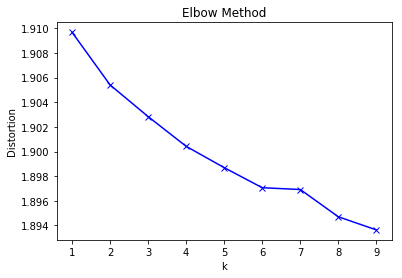

Adjusted Rand Score: 5.104844136249878e-07
Silhouette Score: -0.01912832527529389


In [7]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled)
    kmeanModel.fit(scaled)
    distortions.append(sum(np.min(cdist(scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=0)
y_pred = kmeans.fit_predict(scaled)
pd.crosstab(predict, y_pred)
print( 'Adjusted Rand Score:', adjusted_rand_score(predict, y_pred) )
print( 'Silhouette Score:', silhouette_score(scaled, y_pred, metric='euclidean') )

In [ ]:
lr = LogisticRegression(class_weight = 'balanced')
train = lr.fit(scaled, predict)
lr_scores = cross_val_score(lr, scaled, predict, cv=5)
print('CV Train Scores:', lr_scores.mean() )

lr_report = confusion_matrix( y_true=predict, y_pred=lr.predict(scaled) )
print('Confusion Matrix:\n', lr_report)


In [ ]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample')
train = rfc.fit(scaled, predict)
rfc_scores = cross_val_score(rfc, scaled, predict, cv=5)
print(' CV Train Scores:', rfc_scores.mean() )

rfc_report = confusion_matrix(y_true=predict, y_pred=rfc.predict(scaled))
print('Confusion Matrix:\n',rfc_report)

In [ ]:
feature_df_test = pd.DataFrame()
feature_df_test['word_cnt'] = [len(x.split()) for x in X_test.tolist()]
feature_df_test['exclamation'] = X_test.str.findall(r'[!]').str.len()
feature_df_test['period'] = X_test.str.findall(r'[.]').str.len()
feature_df_test['question'] = X_test.str.findall(r'[?]').str.len()
feature_df_test['Text'] = X_test
feature_df_test['ProfileName'] = y_test

In [ ]:
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_test_lsa = lsa.fit_transform(X_test_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance of all components:", total_variance*100)

tfidf_df_test = pd.DataFrame(data=X_test_lsa)
new_df = pd.concat( [tfidf_df_test, feature_df_test], ignore_index=False, axis=1 )
new_df = new_df.replace( [np.inf, -np.inf], np.nan ).dropna()

test_features = new_df.drop( ['ProfileName','Text'], axis=1 )
test_predict = new_df['ProfileName']
scalar = MinMaxScaler()
test_scaled = scalar.fit_transform(test_features)
test_df = pd.DataFrame(test_scaled)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
y_pred = kmeans.fit_predict(test_scaled)
pd.crosstab(test_predict, y_pred)
print( 'Adjusted Rand Score:', adjusted_rand_score(test_predict, y_pred) )
print( 'Silhouette Score:', silhouette_score(test_scaled, y_pred, metric='euclidean'))
print( 'Logistic Regression Test Score:',lr.score(test_scaled, test_predict))

lr_report = classification_report(digits=6,
                               y_true=test_predict, 
                               y_pred=lr.predict(test_scaled))

print( 'Confusion Matrix:\n', lr_report )
print( 'Random Forest Test Score:', rfc.score(test_scaled, test_predict) )

In [ ]:
rfc_report = classification_report(
    digits=6,
    y_true=test_predict, 
    y_pred=rfc.predict(test_scaled))

print('Clasification report:\n', rfc_report)

rfc_report = confusion_matrix(y_true=test_predict, y_pred=rfc.predict(test_scaled))
print('Confusion Matrix:\n', rfc_report)